# Nicholls-Turton Parameterization Notebook

<h2>Helper functions adapted from interactive_vaporflux.ipynb</h2>

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from a500_utils.helpers import make_tuple
from thermlib import thermfuncsII as tf
from thermlib import thermconst as tc
from importlib import reload
reload(tf)
import pandas as pd
import numpy as np
import scipy.integrate as integrate
plt.style.use('ggplot')

def theta_ft(h,ft_intercept,gamma):
    """
       input h (meters) and the coefficients for the linear
       profile for the free troposphere theta (ft_intercept (K)  and slope gamma (K/m))
       return the free tropospher theta at height h
    """
    theta_top = ft_intercept + h*gamma
    return theta_top

def dmixed_vars(the_vars,tstep,coeffs):
    """
      the_vars[0]= thetabar
      the_vars[1] = h
      the_vars[2] = qv
      
      surface flux from drag law with subsidence and diagnosed deltheta
    """

    deltheta = theta_ft(the_vars[1],coeffs.ft_intercept,coeffs.ft_gamma) - the_vars[0]
    F0 = coeffs.U*coeffs.Cd*(coeffs.sst - the_vars[0])  #surface heat flux
    Fqv0 = coeffs.U*coeffs.Cd*(coeffs.qsfc - the_vars[2])  #surface vapor flux
    Fint = -coeffs.k*F0  #entrainment heat flux
    
    if coeffs.use_NT: # use NT parameterization by calculating we using function
        went = calc_went_NT(the_vars, coeffs, deltheta, F0, Fqv0) # Nicholls-Turton parameterization
        
    else: # use simple we parameterization
        went = -Fint/deltheta  #simple entrainment parameterization
    
    # calculate delta_Fr
    delta_Frstar = 82.0 # Wm^-2
    Frlambda = 7.9 # Wm^-2, using with CTL from Gesso
    delta_Fr = delta_Frstar - Frlambda*coeffs.ft_qv*1000 # convert qt_ft to g kg^-1
    
    Fqvent = -went*( coeffs.ft_qv - the_vars[2])
    wsubs = -coeffs.D*the_vars[1]
    rho=1.
    cp=1004.
    
    derivs=np.empty_like(the_vars)
    
    # higher delta_Fr from drier air at mixed-layer top...hence cloudy air results in less radiative cooling
    derivs[0]=(F0 - Fint)/(the_vars[1]*rho) - delta_Fr/1004./the_vars[1] 
    derivs[1] = went + wsubs
    derivs[2] = (Fqv0 - Fqvent)/the_vars[1]
    return derivs

def calc_went_NT(the_vars, coeffs, deltheta, F0, Fqv0):
    """
       Nicholls-Turton entrainment parameterization
       the_vars and coeffs are inputs into dmixed_vars
       deltheta, F0, Fqv0 are calculated in dmixed_vars
    """
    thetal_m = the_vars[0]
    qt_m = the_vars[2]
    zi = the_vars[1]
    dth = deltheta
    
    thetal_ft = thetal_m + dth
    qt_ft = coeffs.ft_qv
    
    dqt = qt_ft - qt_m
    
    # calculate thetal at z = 3000 m (take qt(z = 3000m) = qt(z = h), so delta_qt = dqt)
    gamma = 6e-3 
    thetal_3000 = thetal_ft + gamma*(3000-zi)
    LTS = thetal_3000 - coeffs.sst # lower tropospheric stability

    # calculate coefficients
    press=tf.find_press(zi)
    Ad,Bd,issat = tf.calc_ABcoeffs(thetal_ft,qt_ft,press)
    Aw,Bw,issat = tf.calc_ABcoeffs(thetal_m,qt_m,press)
    
    invert= tf.t_uos_thetal(thetal_m,qt_m,press)
    T_0 = invert.temp
    lv=tf.L_t(invert.temp)
    Cl =  (Ad*lv/tc.CPD - T_0/tc.EPS)
    del_thv_dry = Ad * dth + Bd * dqt
    del_thv_sat = Aw * dth + Bw * dqt
    
    # account for evaporative cooling (increases we)
    ql_max = invert.ql
    Cl =  (Ad*lv/tc.CPD - T_0/tc.EPS)
    Del_thv = del_thv_dry - Cl * ql_max
    
    # calculate buoyancy integral terms
    rho = 1.
    lcl_press=tf.LCL_thetal(thetal_m,qt_m)
    zb=tf.find_height(lcl_press)

    T1 = zb/zi
    T2 = 0.5 * zb**2 / zi**2
    T3 = (zi-zb)/zi
    T4 = 0.5 * (zi**2 - zb**2) / zi**2
    
    # calculate delta_Fr
    delta_Frstar = 82.0 # Wm^-2
    Frlambda = 7.9 # Wm^-2, using with CTL from Gesso
    delta_Fr = delta_Frstar - Frlambda*qt_ft*1000 # convert qt_ft to g kg^-1

    wtl_0=F0
    wqt_0=Fqv0
    Del_F = delta_Fr/(tc.CPD*rho) # use sensitivity to radiation a la Gesso Fig. 3
    term1 = wtl_0 * (Ad * (T1-T2) + Aw * (T3-T4))
    term2 = wqt_0 * (Bd * (T1-T2) + Bw * (T3-T4))
    term3 = Del_F * (Ad * T2      + Aw * T4)

    Theta_NE = term1 + term2 + term3
    
    # calculate w*
    wstar=(2.5*9.8/T_0*zi*Theta_NE)**(1/3.)
    
    # calculate chi*
    chi_star = Cl * ql_max / (del_thv_dry - del_thv_sat)
    
    # calculate del_m
    Del_m = del_thv_dry + chi_star * (2. - chi_star) * (del_thv_sat - del_thv_dry)
    
    # calculate we
    a2=15.
    Del_thv_NT = Del_thv / (1. + a2 * (1. - Del_m/Del_thv))
    
    A_NT = 0.2
    fac_NT = 2.5

    term4 = Del_thv_NT
    term5 = A_NT * fac_NT * (T2 * del_thv_dry + T4 * del_thv_sat)
    denominator = term4 + term5

    we = A_NT * fac_NT * Theta_NE / denominator
    
    return we
    
     
def calc_lcl(row,psfc):
    """
      find the lcl (in m) for a row in the dataframe
    """
    Tdew = tf.tmr(row['qv'],psfc)
    LCL = tf.LCL(Tdew,row['theta'],psfc)  #kPa
    #
    # rough approximation:  10 kPa = 1 km
    #
    delp=psfc - LCL
    lcl_h = delp*100.
    return lcl_h


def calc_sfc_theta_flux(row,coeffs):
    F0 = coeffs.U*coeffs.Cd*(coeffs.sst - row['theta'])  #surface heat flux
    return F0

def calc_sfc_qvap_flux(row,coeffs):
    Fqv0 = coeffs.U*coeffs.Cd*(coeffs.qsfc - row['qv'])
    return Fqv0

def calc_entflux_theta(row,coeffs):
    flux_ent = -coeffs.k*row['T_flux_0']
    return flux_ent

def calc_went(row,coeffs): # simple entrainment parameterization; results in lower entrainment rates than NT
    went = -row['entflux_theta']/row['deltheta']
    return went
    
def calc_entflux_qv(row,coeffs):
    flux_ent =  -row['went']*( coeffs.ft_qv - row['qv'])
    return flux_ent



<h2>Main functions for integration and output</h2>

In [2]:
def write_hdf(sst, ft_qv, use_NT):
    """Adapted from interactive_vaporflux.ipynb
       sst, sea surface temperature (K)
       ft_qv, mixed-layer top qv (kg kg^-1)
       use_NT, True or False
       
       outputs hdf5 with equilibrium values
    """

    dtout=10.  #minutes
    end_time=8*24.   #hours
    del_time=dtout*60. #seconds
    end_time=end_time*3600. #seconds
    #sst=297
    D=5.e-6  #s-1
    U=7  #m/s
    psfc=100. #kPa
    qsfc=tf.qs_tp(sst,psfc)
    ft_intercept = 292 #K
    ft_gamma = 6.e-3  #K/m
    #ft_qv = 2.e-3
    k=0.2  #entrainment efficiency
    Cd = 1.e-3  #drag coefficient
    tspan = np.arange(0.,end_time,del_time)
    vars_init=[285.,400.,8.e-3]  #theta (K), height (m) qv (kg/kg) to start
    the_tup=dict(D=D,U=U,sst=sst,ft_intercept=ft_intercept,ft_gamma=ft_gamma,
                 qsfc=qsfc,ft_qv=ft_qv,k=k,Cd=Cd,radcool=30.,use_NT=use_NT) # include use_NT
    the_tup=make_tuple(the_tup,'coeffs')
    output=integrate.odeint(dmixed_vars, vars_init, tspan,(the_tup,))
    result=pd.DataFrame.from_records(output,columns=['theta','h','qv'])

    # save time/computation by only doing calculations for the last timestep (equilibrium)
    result['time']=tspan[-1]/3600./24.  #days
    result['deltheta'] = theta_ft(result['h'].values[-1],ft_intercept,ft_gamma) - result['theta'].iloc[-1]
    result['delqv'] = ft_qv - result['qv'].iloc[-1]
    result['LCL'] = calc_lcl(result.iloc[-1], psfc)
    result['q_flux_0']=calc_sfc_qvap_flux(result.iloc[-1],the_tup)
    result['T_flux_0']=calc_sfc_theta_flux(result.iloc[-1],the_tup)
    result['entflux_theta']=calc_entflux_theta(result.iloc[-1],the_tup)
    
    # decide how to calculate entrainment
    the_vars = [result['theta'].iloc[-1],result['h'].iloc[-1],result['qv'].iloc[-1]]
    if use_NT:
        result['went']=calc_went_NT(the_vars, the_tup, result['deltheta'].iloc[-1], result['T_flux_0'].iloc[-1], result['q_flux_0'].iloc[-1])
    else:
        result['went']=calc_went(result.iloc[-1],the_tup)

    result['entflux_qv']=calc_entflux_qv(result.iloc[-1],the_tup)

    with pd.HDFStore('dumpvapor.h5','w') as f:
        f.put('profile',result,format='table')
    
    return None

# ==============================================================

# main function
def calc_equil(sst, ft_qv, use_NT=False):
    """Adapted from nicholls_turton.ipynb
       sst, sea surface temperature (K)
       ft_qv, mixed-layer top qv (kg kg^-1)
       use_NT, True or False
       
       outputs data array out_array with equilibrium values:
       ([thetal_m, qt_m, zi, zb, we, LWP, delta_Fr, LTS, dqt])
    """
    
    write_hdf(sst, ft_qv, use_NT)
    
    # grab HDF5 file 
    with pd.HDFStore('dumpvapor.h5') as f:
        df_result=f['profile']

    # last time step into named tupple
    out=df_result.iloc[-1]
    steady_state=make_tuple(out.to_dict())
    steady_state
        
    # obtain steady-state values
    dth=steady_state.deltheta
    dqt=steady_state.delqv
    thetal_m=steady_state.theta
    qt_m=steady_state.qv
    h=steady_state.h
    press=tf.find_press(steady_state.h)   #kPa
    thetal_ft = steady_state.theta + dth
    qt_ft = steady_state.qv + dqt
    zb = steady_state.LCL
    zi = steady_state.h
    we = steady_state.went
    
    # calculate thetal at z = 3000 m (take qt(z = 3000m) = qt(z = h), so delta_qt = dqt)
    gamma = 6e-3 
    thetal_3000 = thetal_ft + gamma*(3000-h)
    LTS = thetal_3000 - steady_state.theta
    
    # calculate delta_Fr
    delta_Frstar = 82.0 # Wm^-2
    Frlambda = 7.9 # Wm^-2, using with CTL from Gesso
    delta_Fr = delta_Frstar - Frlambda*qt_ft*1000 # convert qt_ft to g kg^-1

    # calculate LWP
    rho = 1.
    LWP = 0.5*rho*(zi-zb)**2
    
    # put all required variables into output array
    out_array = np.array([thetal_m, qt_m, zi, zb, we, LWP, delta_Fr, LTS, dqt])
    
    return out_array

In [3]:
# test functions
sst = 297
ft_qv = 2e-3

test_array = calc_equil(sst, ft_qv, use_NT=True)
print(test_array)

[  2.89095681e+02   9.11758918e-03   1.83042821e+03   4.95462333e+02
   9.28264501e-03   8.91066949e+05   6.62000000e+01   2.09043194e+01
  -7.11758918e-03]


<h2>Integrate across different sst and ft_qv to obtain phase-space of variables</h2>

In [4]:
ft_qv = np.linspace(2e-3,9e-3,10) 
sst = np.linspace(280,300,10)

data_array_NT = np.empty([ft_qv.shape[0],sst.shape[0],test_array.shape[0]])
data_array = np.empty([ft_qv.shape[0],sst.shape[0],test_array.shape[0]])
for i in range(ft_qv.shape[0]):
    for j in range(sst.shape[0]):
        out_array_NT = calc_equil(sst[j], ft_qv[i], use_NT=True)
        out_array = calc_equil(sst[j], ft_qv[i], use_NT=False)
        for k in range(test_array.shape[0]):
            data_array_NT[i,j,k] = out_array_NT[k]
            data_array[i,j,k] = out_array[k]

<h2>Show Gesso Fig. 3, radiation sensitivity</h2>

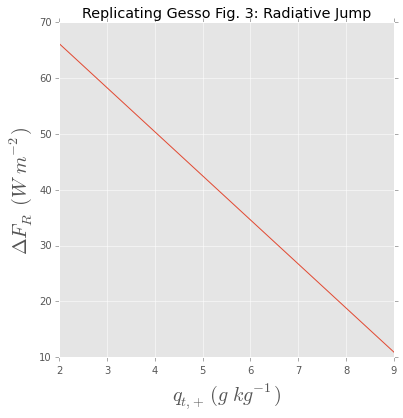

In [5]:
fig1,ax1 = plt.subplots(1,1,figsize=(6,6))

ax1.plot(ft_qv*1000,data_array_NT[:,0,6])
ax1.set_title("Replicating Gesso Fig. 3: Radiative Jump")
ax1.set_xlabel(r"$q_{t,+}\ (g\ kg^{-1})$", fontsize=20)
ax1.set_ylabel(r"$\Delta F_R\ (W\ m^{-2})$", fontsize=20)

<h2>Plot $w_e$ contours </h2>

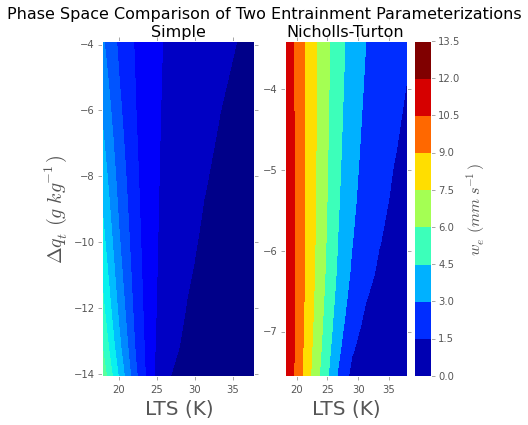

In [6]:
var_index = 4 # index for easy access to variables
var_names = ["thetal_m", "qt_m", "zi", "zb", r"$w_e$", "LWP", "delta_Fr", "LTS", "dqt"] # variable names
units = ["K", "g kg^-1", "m", "m", r"$mm\ s^{-1}$", r"$kg\ {m^-2}$", "W m^-2", "K", "g kg^-1"] # units

#origin = 'lower'
origin = 'upper' # origin location for contour plots

delta = 0.025

# mesh LTS and delta_qv
X_NT, Y_NT = np.meshgrid((data_array_NT[0,:,7]), (data_array_NT[0,:,8])*1000)
X, Y = np.meshgrid((data_array[0,:,7]), (data_array[0,:,8])*1000)

# convert units as necessary
if var_index == 4: # for we
    factor = 1000
elif var_index == 5: # for LWP
    factor = 0.001
else:
    factor = 1
    
Z_NT = (data_array_NT[:,:,var_index]*factor)
Z = (data_array[:,:,var_index]*factor)

fig,ax = plt.subplots(1,2,figsize=(6,6))

# map simple entrainment param. contour colours to be the same as NT entrainment contours
CS0 = ax[0].contourf(X, Y, Z, 10,
                  #[-1, -0.1, 0, 0.1],
                  #alpha=0.5,
                  cmap=plt.cm.jet, 
                  origin=origin, vmin=np.min(Z_NT[:]), vmax=np.max(Z_NT[:]))

CS1 = ax[1].contourf(X_NT, Y_NT, Z_NT, 10,
                  #[-1, -0.1, 0, 0.1],
                  #alpha=0.5,
                  cmap=plt.cm.jet,
                  origin=origin, vmin=np.min(Z_NT[:]), vmax=np.max(Z_NT[:]))


fig.suptitle("Phase Space Comparison of Two Entrainment Parameterizations",fontsize=16)
ax[0].set_title("Simple".format(var_names[var_index], units[var_index]),fontsize=16)
ax[1].set_title("Nicholls-Turton".format(var_names[var_index], units[var_index]),fontsize=16)
ax[0].set_xlabel('LTS (K)',fontsize=20)
ax[1].set_xlabel('LTS (K)',fontsize=20)
ax[0].set_ylabel(r'$\Delta q_t\ (g\ kg^{-1}) $',fontsize=20)

cbar = plt.colorbar(CS1)
cbar.ax.set_ylabel(r"$w_e\ (mm\ s^{-1})$",fontsize=16)

- Contour plots above show that by varying sst and ft_qv, LTS range remains the same. However, $\Delta q_t$ has a much larger range for the simple entrainment parameterization, indicating the potential for much drier air at ML top for the simple entrainment.

- $w_e$ is much higher at low LTS for NT than simple. 


- higher $w_e$ for NT due to consideration of evaporative cooling and $\chi$*

In [10]:
print("max NT w_e = {}, max simple w_e = {}, ratio = {}".format(np.max(Z_NT),np.max(Z),np.max(Z_NT)/np.max(Z)))

max NT w_e = 12.164507052791047, max simple w_e = 5.855408862093616, ratio = 2.0774820920774433


- Simple parameterization shows more variance in the y-axis than the NT parameterization, especially at low LTS